# Colour visualisation

In [3]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt

# custom
from reflectance import spectrum_utils, file_ops, optimisation_pipeline, plotting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sentinel-vision

In [16]:
S2_response_fn_fp = file_ops.RESOURCES_DIR_FP / "satellite_response_functions" / "S2-SRF_COPE-GSEG-EOPG-TN-15-0007_3.2.xlsx"
response_fns_S2A = pd.read_excel(S2_response_fn_fp, sheet_name="Spectral Responses (S2A)", header=0, index_col=0)
response_fns_S2B = pd.read_excel(S2_response_fn_fp, sheet_name="Spectral Responses (S2B)", header=0, index_col=0)
# combine the two by averaging (minor technical differences between satellites in the same constellation)
S2_response_fns = pd.DataFrame((response_fns_S2A.values + response_fns_S2B.values) / 2, index=response_fns_S2A.index, columns=response_fns_S2A.columns).head()
S2_response_fns.head()

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,S2A_SR_AV_B1,S2A_SR_AV_B2,S2A_SR_AV_B3,S2A_SR_AV_B4,S2A_SR_AV_B5,S2A_SR_AV_B6,S2A_SR_AV_B7,S2A_SR_AV_B8,S2A_SR_AV_B8A,S2A_SR_AV_B9,S2A_SR_AV_B10,S2A_SR_AV_B11,S2A_SR_AV_B12
SR_WL,,,,,,,,,,,,,
300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
prism_spectra = spectrum_utils.load_spectra()
emulated_S2_df = spectrum_utils.visualise_satellite_from_prism(prism_spectra, S2_response_fns, bois=["B2", "B3", "B4", "B8A"])   # S2

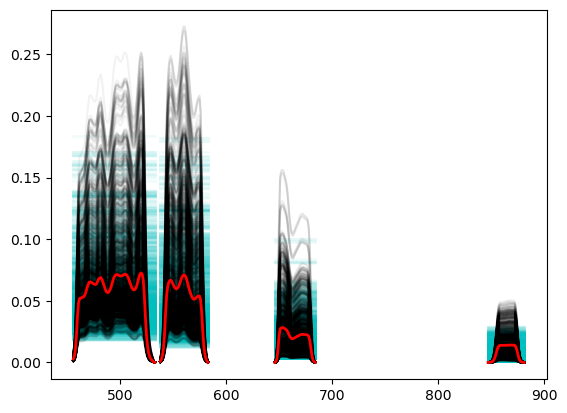

In [11]:
interped_prism = spectrum_utils.interp_df(prism_spectra)
S2_band_vals_df = spectrum_utils.calculate_band_values(S2_response_fns, bois=["B2", "B3", "B4", "B8A"], interped_prism=interped_prism)
S2_continuous_response_df = interped_prism * S2_band_vals_df
S2_mean_response_df = S2_continuous_response_df.mean(axis=0, skipna=True)
S2_flattened_mean_response_df = spectrum_utils.fill_clumps_with_mean(S2_continuous_response_df)

lim_bands = S2_response_fns.index[(S2_response_fns.index >= min(prism_spectra.columns)) & (S2_response_fns.index <= max(prism_spectra.columns))]
plt.plot(lim_bands, S2_continuous_response_df.T, alpha=0.05, color="k");
plt.plot(lim_bands, S2_mean_response_df, color="r", linewidth=2);
plt.plot(lim_bands, S2_flattened_mean_response_df.T, alpha=0.05, color="c", linewidth=2, zorder=-1);

Text(0, 0.5, 'Reflectance')

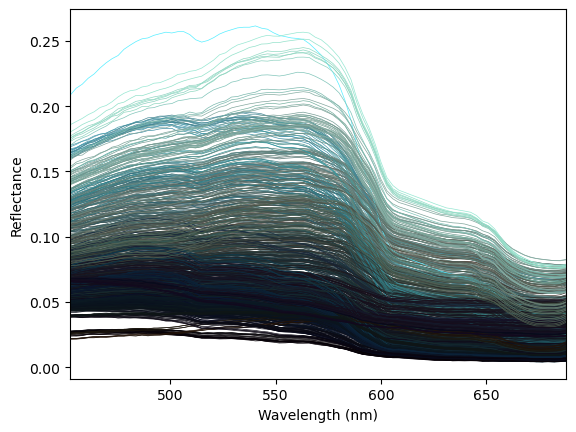

In [12]:
s2_rgbs = plotting.visualise_spectral_colours(emulated_S2_df.values, [2,98])

N_spectra = 1000
fig, ax = plt.subplots()
cropped_prism = spectrum_utils.crop_spectra_to_range(prism_spectra, spectrum_utils.SENSOR_RANGE)
for r, row in cropped_prism.iloc[:N_spectra,:].iterrows():
    ax.plot(row, c=s2_rgbs[r,:], lw=0.5)
ax.set_xlim(min(cropped_prism.columns), max(cropped_prism.columns))
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Reflectance")

## PLANET DOVE Vision

In [13]:
# load response functions
planet_response_fns_fp = file_ops.RESOURCES_DIR_FP / "satellite_response_functions" / "dove_r.csv"
planet_response_fns = pd.read_csv(planet_response_fns_fp, index_col=0)
planet_response_fns.head()

,Blue,Green,Red,NIR
Wavelength (nm),,,,
400,0.0,0.0,0.0,0.0
401,0.0,0.0,0.0,0.0
402,0.0,0.0,0.0,0.0
403,0.0,0.0,0.0,0.0
404,0.0,0.0,0.0,0.0


In [14]:
# planet has loads of small values in between the main peaks: for now, casting to nan
planet_response_fns[planet_response_fns < 0.01] = np.nan

emulated_planet_df = spectrum_utils.visualise_satellite_from_prism(prism_spectra, planet_response_fns, bois=["Blue", "Green", "Red", "NIR"])   # planet
emulated_planet_df.head()

,B2,B3,B4
0,0.035377,0.112722,0.109926
1,0.035540,0.112711,0.109368
2,0.032450,0.102784,0.100149
3,0.035029,0.113642,0.110784
4,0.036526,0.115683,0.111724


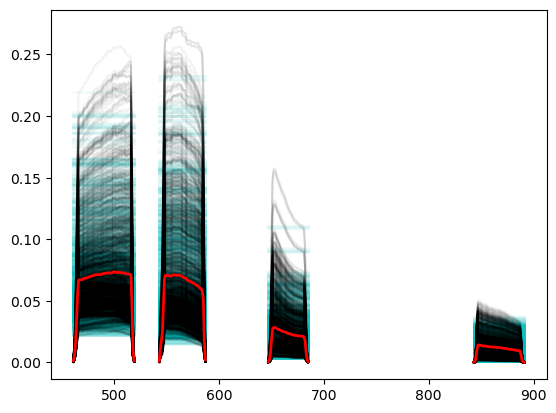

In [15]:
planet_band_vals_df = spectrum_utils.calculate_band_values(planet_response_fns, bois=["Blue", "Green", "Red", "NIR"], interped_prism=interped_prism)
planet_continuous_response_df = interped_prism.loc[:, planet_band_vals_df.index] * planet_band_vals_df
planet_mean_response_df = planet_continuous_response_df.mean(axis=0, skipna=True)
planet_flattened_mean_response_df = spectrum_utils.fill_clumps_with_mean(planet_continuous_response_df)

planet_lim_bands = planet_response_fns.index.intersection(interped_prism.columns)
plt.plot(planet_lim_bands, planet_continuous_response_df.T, alpha=0.05, color="k");
plt.plot(planet_lim_bands, planet_mean_response_df, color="r", linewidth=2);
plt.plot(planet_lim_bands, planet_flattened_mean_response_df.T, alpha=0.05, color="c", linewidth=2, zorder=-1);

Text(0, 0.5, 'Reflectance')

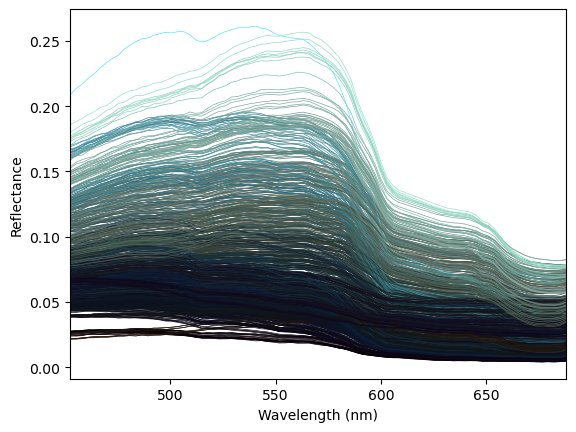

In [17]:
planet_rgbs = plotting.visualise_spectral_colours(emulated_planet_df.values, [2,98])

N_spectra = 1000
fig, ax = plt.subplots()
cropped_prism = spectrum_utils.crop_spectra_to_range(prism_spectra, spectrum_utils.SENSOR_RANGE)
for r, row in cropped_prism.iloc[:N_spectra,:].iterrows():
    ax.plot(row, c=planet_rgbs[r,:], lw=0.5)
ax.set_xlim(min(cropped_prism.columns), max(cropped_prism.columns))
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Reflectance")

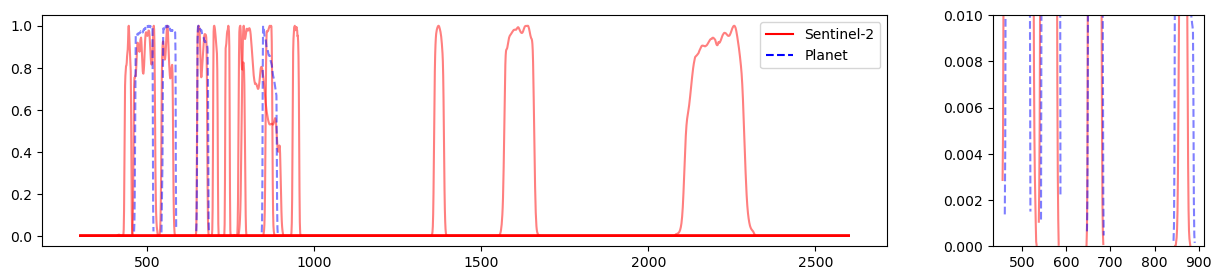

In [18]:
# comparing S2 and Planet response functions
fig, axs = plt.subplots(1,2, figsize=(15,3), width_ratios=[4,1])
axs[0].plot(S2_response_fns, ls="-", alpha=0.5,c="r")
axs[0].plot(planet_response_fns, ls="--", alpha=0.5,c="b")
axs[0].plot([],[],ls="-",label="Sentinel-2",c="r")
axs[0].plot([],[],ls="--",label="Planet",c="b")

axs[1].plot(S2_continuous_response_df.mean(axis=0), ls="-", alpha=0.5, c="r")
axs[1].plot(planet_continuous_response_df.mean(axis=0), ls="--", alpha=0.5, c="b")
axs[1].set_ylim(0,0.01)
axs[0].legend();

# Visualising colours of spectra

In [19]:
glob_cfg, _ = file_ops.instantiate_single_configs_instance(run_ind = 0)
AOP_model = spectrum_utils.load_aop_model(aop_group_num=1)
AOP_args = (
    AOP_model.bb_m.values,
    AOP_model.bb_c.values,
    AOP_model.Kd_m.values,
    AOP_model.Kd_c.values,
)
wvs = AOP_model.index

endmember_class_schema = "three_endmember"
endmember_array = optimisation_pipeline.GenerateEndmembers(
    endmember_class_map = glob_cfg.endmember_schema[endmember_class_schema],
    endmember_dimensionality_reduction = "mean"
    ).generate_endmembers()

endmember_cats = endmember_array.index

In [20]:
algae_sim_spectra, metadata = spectrum_utils.simulate_spectra(endmember_array, wvs, AOP_args, (1, 0, 0), N=1)  # Rb values: algae, coral, sand
coral_sim_spectra, metadata = spectrum_utils.simulate_spectra(endmember_array, wvs, AOP_args, (0, 1, 0), N=1)  # Rb values: algae, coral, sand
sand_sim_spectra, metadata = spectrum_utils.simulate_spectra(endmember_array, wvs, AOP_args, (0, 0, 1), N=1)  # Rb values: algae, coral, sand

all_spectra = np.concatenate([algae_sim_spectra, coral_sim_spectra, sand_sim_spectra], axis=0)
flattened_sim_spectra = all_spectra.reshape(-1, all_spectra.shape[-1])

Generating simulated spectra:   0%|          | 0/10000 [00:00<?, ?it/s]

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Generating simulated spectra:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/10000 [00:00<?, ?it/s]

In [21]:
spectra_df = pd.DataFrame(flattened_sim_spectra, columns = wvs)
norm_rgb_values = plotting.generate_spectra_color(spectra_df)

In [22]:
norm_rgb_values

array([[0.56749323, 0.70342356, 0.31557623],
       [0.56764419, 0.71640237, 0.31192145],
       [0.57303313, 0.71097954, 0.31311323],
       ...,
       [0.04955887, 0.32076478, 0.60392573],
       [0.05041067, 0.31934268, 0.60354128],
       [0.05022256, 0.31988319, 0.60380919]])

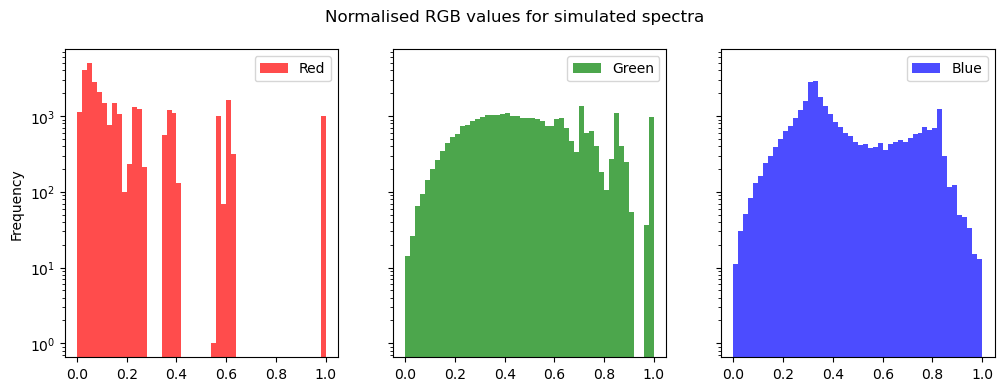

In [23]:
# plot histogram of red, green, and blue values
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

norm_reds = norm_rgb_values[:, 0]
norm_greens = norm_rgb_values[:, 1]
norm_blues = norm_rgb_values[:, 2]

plt.suptitle("Normalised RGB values for simulated spectra")
for i, (ax, rgb, colour) in enumerate(zip(axs, [norm_reds, norm_greens, norm_blues], ["Red", "Green", "Blue"])):
    ax.hist(rgb, bins=50, color=colour, alpha=0.7, label=colour)
    ax.set_yscale('log')
    ax.legend()
axs[0].set_ylabel("Frequency");

AttributeError: 'DataFrame' object has no attribute 'reshape'

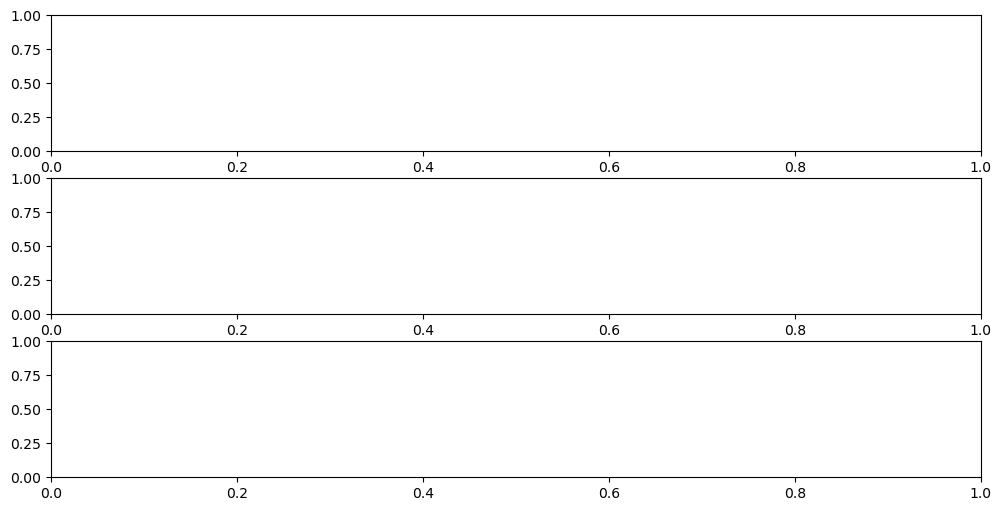

In [24]:
# plot spectra in RGB space
subset_interval = 10

from tqdm.auto import tqdm

fig, axes = plt.subplots(nrows=3, figsize=(12, 6))

for s, (spectra, spectra_title) in enumerate(zip([algae_sim_spectra, coral_sim_spectra, sand_sim_spectra], ["algae", "coral", "sand"])):
    # flatten spectrum
    flat_spectra = spectra.reshape(-1, 113)
    # select subset
    lim_spectra = flat_spectra[::subset_interval]
    
    for i, spectrum in tqdm(enumerate(lim_spectra), total=len(lim_spectra), desc=f"Plotting {spectra_title} spectra"):
        axes[s].plot(wvs, spectrum, color=norm_rgb_values[len(flat_spectra)*s:(s+1)*len(flat_spectra)][::subset_interval][i], alpha=0.5)
        
    axes[s].set_title(f"{list(endmember_cats)[s]} spectra")
        
plt.tight_layout()

# AOP model visualisations

In [ ]:
AOP_model = spectrum_utils.load_aop_model(aop_group_num=1)
red_hex = "#C64922"
yellow_hex = "#E6CC4F"
styles = ['-', '-', '--', ':']
    
# compare AOP models    
bb_f, bb_axes = plt.subplots(1, 1, figsize=(9, 4))
K_f, K_axes = plt.subplots(1, 1, figsize=(9, 4))

for aop_group_num in range(1, 4):
    AOP_model = spectrum_utils.load_aop_model(aop_group_num=aop_group_num)
    wvs = AOP_model.index

    K_axes.plot(wvs, AOP_model.loc[wvs].Kd_m + AOP_model.loc[wvs].Kd_c, ls=styles[aop_group_num], color=yellow_hex, label=f"Group {aop_group_num}", alpha=1)
    bb_axes.plot(wvs, AOP_model.loc[wvs].bb_m + AOP_model.loc[wvs].bb_c, ls=styles[aop_group_num], color=red_hex, label=f"Group {aop_group_num}", alpha=1)

for ax in (bb_axes, K_axes):
    # ax.patch.set_alpha(0)
    ax.set_xlim(min(wvs), max(wvs))
    # set outside ticks and lines to be white
    [ax.spines[pos].set_color('white') for pos in ax.spines.keys()]
    # set ticks to be white
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')
    
# remove numbers from bb_axes x axis
bb_axes.set_xticklabels([])
K_axes.set_xlabel("Wavelength (nm)", color="white")

# save figs
bb_f.savefig(file_ops.RESULTS_DIR_FP / "figures/bb_models.png", dpi=300, transparent=True)
K_f.savefig(file_ops.RESULTS_DIR_FP / "figures/K_models.png", dpi=300, transparent=True)


In [ ]:
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter

def update_K(frame):
    K_axes.cla()
    K_axes.patch.set_alpha(0)
    K_f.patch.set_alpha(0)
    for aop_group_num in range(1, 4):
        AOP_model = spectrum_utils.load_aop_model(aop_group_num=aop_group_num)
        wvs = AOP_model.index

        K_axes.plot(wvs[:frame], (AOP_model.loc[wvs[:frame]].Kd_m + AOP_model.loc[wvs[:frame]].Kd_c), ls=styles[aop_group_num], color=yellow_hex, label=f"Group {aop_group_num}", alpha=1)
    
    # Set up the axes
    K_axes.set_xlim(min(AOP_model.index), max(AOP_model.index))
    plotting.format_axis_for_ppt(K_axes)
    K_axes.set_xticklabels([])
    K_axes.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')
    K_axes.set_xlabel("Wavelength (nm)", color="white")
    return K_axes

# Create the figures and axes
K_f, K_axes = plt.subplots(1, 1, figsize=(9, 4), dpi=300)

# Create the animation
ani_bb = FuncAnimation(K_f, update_K, frames=len(AOP_model.index), blit=False, repeat=False, interval=60, repeat_delay=1000)

writer = FFMpegWriter(fps=30, metadata={'loop': 0}, extra_args=['-loop', '1'])
ani_bb.save(file_ops.RESULTS_DIR_FP / "figures/K_models_animation.gif", writer=writer, savefig_kwargs={'transparent': True}, dpi=200)

In [ ]:
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter

def update_bb(frame):
    bb_axes.cla()
    bb_axes.patch.set_alpha(0)
    bb_f.patch.set_alpha(0)
    for aop_group_num in range(1, 4):
        AOP_model = spectrum_utils.load_aop_model(aop_group_num=aop_group_num)
        wvs = AOP_model.index

        bb_axes.plot(wvs[:frame], (AOP_model.loc[wvs[:frame]].bb_m + AOP_model.loc[wvs[:frame]].bb_c), ls=styles[aop_group_num], color=red_hex, label=f"Group {aop_group_num}", alpha=1)
    
    # Set up the axes
    bb_axes.set_xlim(min(AOP_model.index), max(AOP_model.index))
    plotting.format_axis_for_ppt(bb_axes)
    bb_axes.set_xticklabels([])
    bb_axes.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')

    return bb_axes

# Create the figures and axes
bb_f, bb_axes = plt.subplots(1, 1, figsize=(9, 4), dpi=300)

# Create the animation
ani_bb = FuncAnimation(bb_f, update_bb, frames=len(AOP_model.index), blit=False, repeat=False, interval=60, repeat_delay=1000)


writer = FFMpegWriter(fps=30, metadata={'loop': 0}, extra_args=['-loop', '1'])
ani_bb.save(file_ops.RESULTS_DIR_FP / "figures/bb_models_animation.mp4", writer=writer, savefig_kwargs={'transparent': True}, dpi=200)

# Validation spectra

In [ ]:
# benthic counts data
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data.csv")
# spectral data (PRISM-measured reflectance from nearby pixels)
spectra_raw = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_spectra.csv")
spectra_raw.columns = spectra_raw.columns.astype(float)


fig, ax = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

NIR_wvs = (750, 1100)
SENSOR_LIMS = (450, 690)

ax[0].plot(spectra_raw.columns, spectra_raw.values.T, color=(0,0,0,0.05), lw=0.5);
# shade NIR waveband: (https://www.lidsen.com/journals/aeer/aeer-02-03-017)
ax[0].axvspan(min(NIR_wvs), max(spectra_raw.columns) if max(spectra_raw.columns) < max(NIR_wvs) else max(spectra_raw.columns), color='lightgrey', alpha=0.5, zorder=-2, label="NIR wavelengths")
ax[0].set_title("Raw spectra")
ax[0].legend()

# sun glint correction - subtract values between 750 and 1100 (NIR) from rest of data
spectra_deglinted = spectrum_utils.deglint_spectra(spectra_raw, NIR_wvs)

# calculate sub-surface reflectance (from Lee et al. 1998)
spectra_corrected = spectrum_utils.retrieve_subsurface_reflectance(spectra_deglinted)

ax[1].plot(spectra_deglinted.columns, spectra_deglinted.values.T, color=(0,0,0,0.05), lw=0.5);
ax[1].set_title("Sunglint-corrected spectra")

# plot corrected spectra
ax[2].plot(spectra_corrected.columns, spectra_corrected.values.T, color=(0,0,0,0.05), lw=0.5);
ax[2].set_title("Sub-surface reflectance")

for a in ax:
    a.set_xlim(spectra_corrected.columns.min(), spectra_corrected.columns.max())
    a.set_ylabel("Reflectance")
ax[2].set_xlabel("Wavelength (nm)")
    
plt.tight_layout()

In [ ]:
# clip spectra to AOP valid range (instrument calibration limitations)
ind = (spectra_corrected.columns > min(SENSOR_LIMS)) & (spectra_corrected.columns < max(SENSOR_LIMS))
prism_spectra = spectra_corrected.loc[:, ind]

validation_spectra_f, validation_spectra_ax = plt.subplots(1, 1, figsize=(5, 10), dpi=300)
validation_spectra_ax.plot(prism_spectra.columns, prism_spectra.values.T, color=(0,1,1,0.1), lw=0.5);
validation_spectra_ax.set_xlim(min(prism_spectra.columns), max(prism_spectra.columns));

validation_spectra_ax = plotting.format_axis_for_ppt(validation_spectra_ax) 
# [validation_spectra_ax.spines[pos].set_color('white') for pos in validation_spectra_ax.spines.keys()]
# # set ticks to be white
# validation_spectra_ax.tick_params(axis='x', colors='white')
# validation_spectra_ax.tick_params(axis='y', colors='white')
validation_spectra_ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')
validation_spectra_ax.set_xlabel("Wavelength (nm)", color="white")
validation_spectra_ax.set_ylabel("Reflectance", color="white")
validation_spectra_ax.set_yticklabels([])
validation_spectra_f.savefig(file_ops.RESULTS_DIR_FP / "figures/validation_spectra.png", dpi=300, transparent=True)

In [ ]:
# create animation of spectra being added to figure, one by one
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(1, 1, dpi=300)
ax.set_xlim(min(prism_spectra.columns), max(prism_spectra.columns))
lim_prism_spectra = prism_spectra.iloc[::10, :]
# order spectrum by size of first value
lim_prism_spectra = lim_prism_spectra.iloc[np.argsort(lim_prism_spectra.iloc[:, 0])]



# ax.set_ylim([0, 0.27])

def update(i):
    ax.cla()
    fig.patch.set_alpha(0.0)
    ax.patch.set_alpha(0.0)
    ax.plot(lim_prism_spectra.columns, lim_prism_spectra[:i].values.T, color=(0, 1, 1, 0.5), lw=0.5)
    ax.set_xlim(min(lim_prism_spectra.columns), max(lim_prism_spectra.columns))
    # format axis
    plotting.format_axis_for_ppt(ax)
    ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.05, which='both')
    # set ytick labels empty
    ax.set_yticklabels([])
    ax.set_ylim(0, np.max(lim_prism_spectra.values.T)*1.1)
    return ax

ani = FuncAnimation(fig, update, frames=range(lim_prism_spectra.shape[0]), interval=1, repeat=False)
writer = FFMpegWriter(fps=30, metadata={'loop': 0}, extra_args=['-loop', '-1'])

# save animation with transparent background
ani.save(file_ops.RESULTS_DIR_FP / "figures/validation_spectra_animation_static.gif", writer=writer, savefig_kwargs={'transparent': True})

## Wavelength?

In [ ]:
# plot sinusoid of varying wavelengths between min(wvs) and max(wvs)
import numpy as np
import matplotlib.pyplot as plt

# Define the range of wavelengths (in nm)
min_wavelength = 10
max_wavelength = 1000

# Define the x-axis range (in arbitrary units)
x = np.linspace(0, 4 * np.pi, 1000)

# Calculate the wavelength at each point on the x-axis
wavelengths = np.linspace(min_wavelength, max_wavelength, len(x))

# Calculate the frequency at each point on the x-axis (inverse of wavelength)
frequencies = 1 / wavelengths

# Generate the sinusoidal wave with varying frequency
y = np.sin(np.cumsum(frequencies) * 2 * np.pi)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the sinusoid
ax.plot(x, y)

# Add labels and title
ax.set_xlabel('X (arbitrary units)')
ax.set_ylabel('Amplitude')
ax.set_title('Sinusoid with Varying Wavelength')

# Show the plot
plt.show()

# Depth

In [ ]:
import matplotlib
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(3, 10), dpi=200)

# Initialize the bar with a value of 0
bar = ax.bar(0, 0, width=0.1, color='blue')

# format
ax.set_xlim(-0.15, 0.15)
ax.set_ylim(-10.5, 0)
plotting.format_axis_for_ppt(ax)
ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.05, which='both')
ax.set_xticklabels([])
ax.set_ylabel("Depth (m)", color="white", labelpad=0)  # Adjust labelpad to prevent cutoff
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.patch.set_alpha(0.0)
fig.patch.set_alpha(0.0)
fig.subplots_adjust(right=0.75)  # Adjust the right margin to prevent cutoff

n_frames = 100
max_depth = 10

lin = np.linspace(0,1,n_frames)
heights = (max_depth * (1-lin**2))[::-1]

# Define the colormap
start_hex = "#72F4F6"
end_hex = "#0f2e5a"
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("custom", [start_hex, end_hex], N=n_frames)

# Define the update function for the animation
def update(frame):
    height = -frame  # Height decreases from 0 to -10
    # for h in heights:
    color = cmap(int(frame*(n_frames/max_depth)))
    bar[0].set_height(height)  # Update bar height
    bar[0].set_color(color)  # Update bar color
    return bar

ani = FuncAnimation(fig, update, frames=heights, repeat=False)

# save animation with transparent background
writer = FFMpegWriter(fps=30, extra_args=['-loop', '-1'])
# writer = PillowWriter(fps=40)
ani.save(file_ops.RESULTS_DIR_FP / "figures/height.mp4", writer=writer, savefig_kwargs={'transparent': True})

# What is Kaneohe Bay?
Visualising the distributions of the different sites

In [ ]:
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data.csv")
import matplotlib.colors as mcolors

# Get colours from a sequential colormap
cmap = plotting.ColourMapGenerator().get_cmap("seq")
# Generate colors for each point
colours = [mcolors.rgb2hex(cmap(step)) for step in np.linspace(0, 1, len(validation_data.Locale.unique()))]


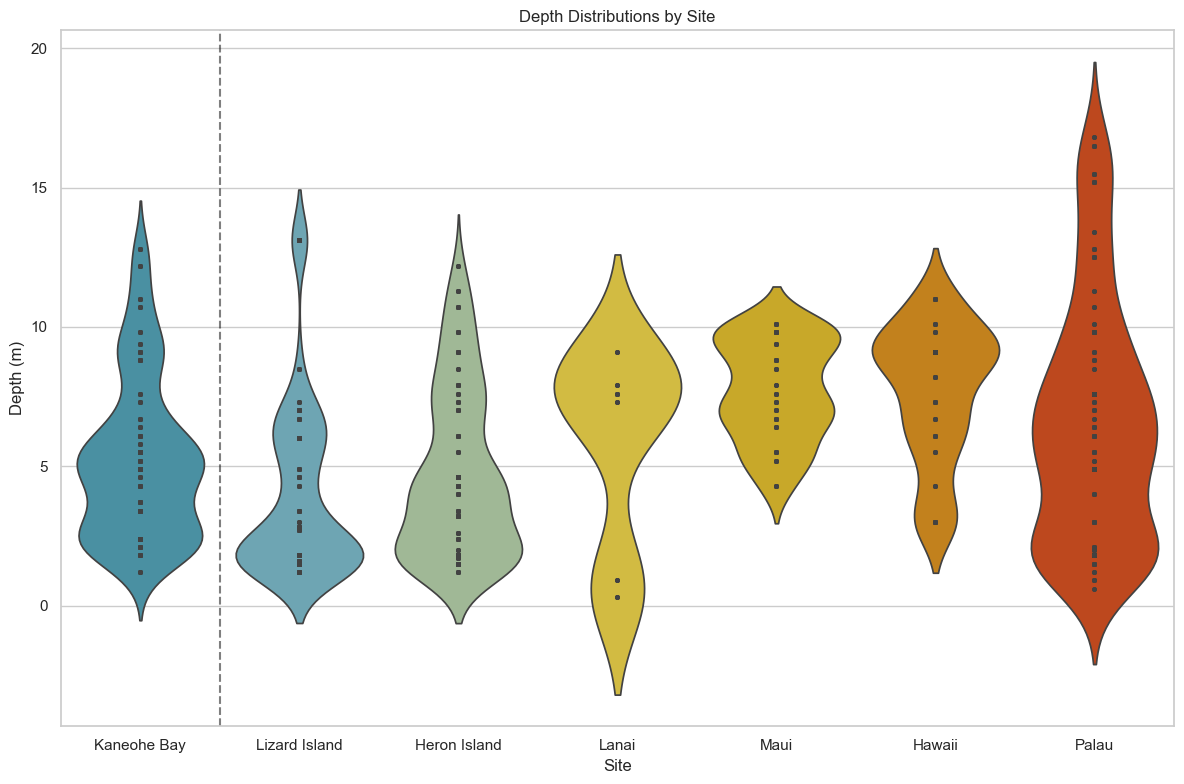

In [ ]:
# Reorder validation_data to have Kaneohe Bay as the first entry
validation_data_reordered = pd.concat([validation_data[validation_data["Locale"] == "Kaneohe Bay"], 
                                       validation_data[validation_data["Locale"] != "Kaneohe Bay"]])

# Plot depth distributions
fig, ax = plt.subplots(figsize=(12, 8))
sns.violinplot(x="Locale", y="Depth", hue="Locale", data=validation_data_reordered, ax=ax, inner="point", palette=colours)
ax.set_xlabel("Site")
ax.set_ylabel("Depth (m)")
ax.set_title("Depth Distributions by Site")
ax.axvline(0.5, color="black", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
benthic_types

Index(['algCCA', 'algCyano', 'algMacBrn', 'algMacGrn', 'algMacMix',
       'algMacRed', 'algMacUnk', 'algTurf', 'crlCoral', 'crlBleach', 'othOcto',
       'othSeagr', 'othClam', 'othInvert', 'othOther', 'othSponge',
       'othUrchin', 'sedLimest', 'sedMud', 'sedRubble', 'sedSand'],
      dtype='object')

In [ ]:
benthic_types = validation_data.columns[11:-2]
benthic_validation = validation_data[list(benthic_types) + ["Locale"]].copy()

benthic_validation[benthic_types] = benthic_validation[benthic_types].astype(float)
benthic_validation.loc[:, benthic_types] = benthic_validation[benthic_types].div(benthic_validation[benthic_types].sum(axis=1), axis=0) * 100
benthic_validation

,algCCA,algCyano,algMacBrn,algMacGrn,algMacMix,algMacRed,algMacUnk,algTurf,crlCoral,crlBleach,...,othClam,othInvert,othOther,othSponge,othUrchin,sedLimest,sedMud,sedRubble,sedSand,Locale
0,3.000000,2.0,0.0,1.0,0.0,4.0,0.0,62.000000,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.000000,Lizard Island
1,3.000000,2.0,0.0,1.0,0.0,4.0,0.0,62.000000,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.000000,Lizard Island
2,3.000000,2.0,0.0,1.0,0.0,4.0,0.0,62.000000,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.000000,Lizard Island
3,3.000000,2.0,0.0,1.0,0.0,4.0,0.0,62.000000,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.000000,Lizard Island
4,3.000000,2.0,0.0,1.0,0.0,4.0,0.0,62.000000,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.000000,Lizard Island
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,3.061224,0.0,0.0,0.0,0.0,0.0,0.0,57.142857,35.714286,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.061224,Palau
1934,3.061224,0.0,0.0,0.0,0.0,0.0,0.0,57.142857,35.714286,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.061224,Palau
1935,10.000000,0.0,0.0,0.0,0.0,2.0,0.0,38.000000,48.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,Palau
1936,10.000000,0.0,0.0,0.0,0.0,2.0,0.0,38.000000,48.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,Palau


In [ ]:
benthic_grouped = benthic_validation.set_index("Locale")
# take mean by index (locale)
benthic_grouped = benthic_grouped.groupby("Locale").mean()
benthic_grouped

,algCCA,algCyano,algMacBrn,algMacGrn,algMacMix,algMacRed,algMacUnk,algTurf,crlCoral,crlBleach,...,othSeagr,othClam,othInvert,othOther,othSponge,othUrchin,sedLimest,sedMud,sedRubble,sedSand
Locale,,,,,,,,,,,,,,,,,,,,,
Hawaii,12.809859,0.000000,0.126761,0.000000,0.000000,0.267606,0.000000,64.021127,10.605634,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.169014,0.000000,0.0,0.000000,12.000000
Heron Island,5.726078,0.114504,0.917692,1.418601,0.969383,1.781420,0.000000,31.793045,38.479342,0.101987,...,0.033079,0.000000,0.087137,0.0,0.022901,0.000000,0.000000,0.0,1.043629,15.171823
Kaneohe Bay,7.783263,0.242280,0.232779,0.200113,0.462784,1.743869,0.128854,53.320212,30.091719,0.023753,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.242280,5.509092
Lanai,10.082067,0.000000,4.331307,1.519757,0.607903,4.246201,0.000000,19.379939,57.100304,0.294833,...,0.000000,0.000000,0.580547,0.0,0.714286,0.000000,0.000000,0.0,0.000000,1.142857
Lizard Island,2.783970,1.066752,0.870956,0.608518,0.943868,2.742957,0.136724,57.260914,4.992034,0.018868,...,0.000000,0.192307,0.059583,0.0,0.133187,0.000000,0.000000,0.0,6.938761,16.312438
Maui,4.969849,0.000000,0.000000,0.059259,0.000000,0.059858,0.000000,45.888107,33.245986,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.032922,0.000000,0.0,0.000000,15.744019
Palau,13.060725,0.000000,1.762173,1.135195,0.877573,0.642678,0.000000,27.680205,36.679741,0.000000,...,0.000000,0.000000,0.232041,0.0,0.160819,0.000000,0.056855,0.0,0.017544,16.599668


In [ ]:
class_map = file_ops.read_yaml(file_ops.CONFIG_DIR_FP / "glob_cfg.yaml")["endmember_map"]
# apply class map to columns, summing
benthic_grouped = spectrum_utils.convert_df_classes(benthic_grouped.T, class_map).T

# additionally sum any columns containing "coral" in the header
coral_cols = [col for col in benthic_grouped.columns if "coral" in col]
benthic_grouped["coral"] = benthic_grouped[coral_cols].sum(axis=1)
benthic_grouped = benthic_grouped.drop(columns=coral_cols)


# rename columns
column_dict = {
    "algae_crustose_coralline": "CCA",
    "algae_fleshy_green": "Fleshy Green Algae",
    "algae_fleshy_red": "Fleshy Red Algae",
    "algae_fleshy_brown": "Fleshy Brown Algae",
    "algae_turf": "Turf Algae",    
}
benthic_grouped = benthic_grouped.rename(columns=column_dict)

In [ ]:
benthic_grouped

,Fleshy Brown Algae,Fleshy Green Algae,Fleshy Red Algae,Turf Algae,mud,sand,seagrass,coral
Locale,,,,,,,,
Hawaii,0.126761,0.000000,0.267606,64.021127,0.0,12.000000,0.000000,23.415493
Heron Island,0.917692,2.502488,1.781420,31.793045,0.0,16.317439,0.033079,46.544799
Lanai,4.331307,2.127660,4.246201,19.379939,0.0,1.437690,0.000000,67.182371
Lizard Island,0.870956,2.755862,2.742957,57.260914,0.0,23.270066,0.000000,12.714169
Maui,0.000000,0.059259,0.059858,45.888107,0.0,15.744019,0.000000,38.215835
Palau,1.762173,2.012768,0.642678,27.680205,0.0,16.674067,0.000000,50.835250
Kaneohe Bay,0.232779,1.034030,1.743869,53.320212,0.0,5.775126,0.000000,37.893984


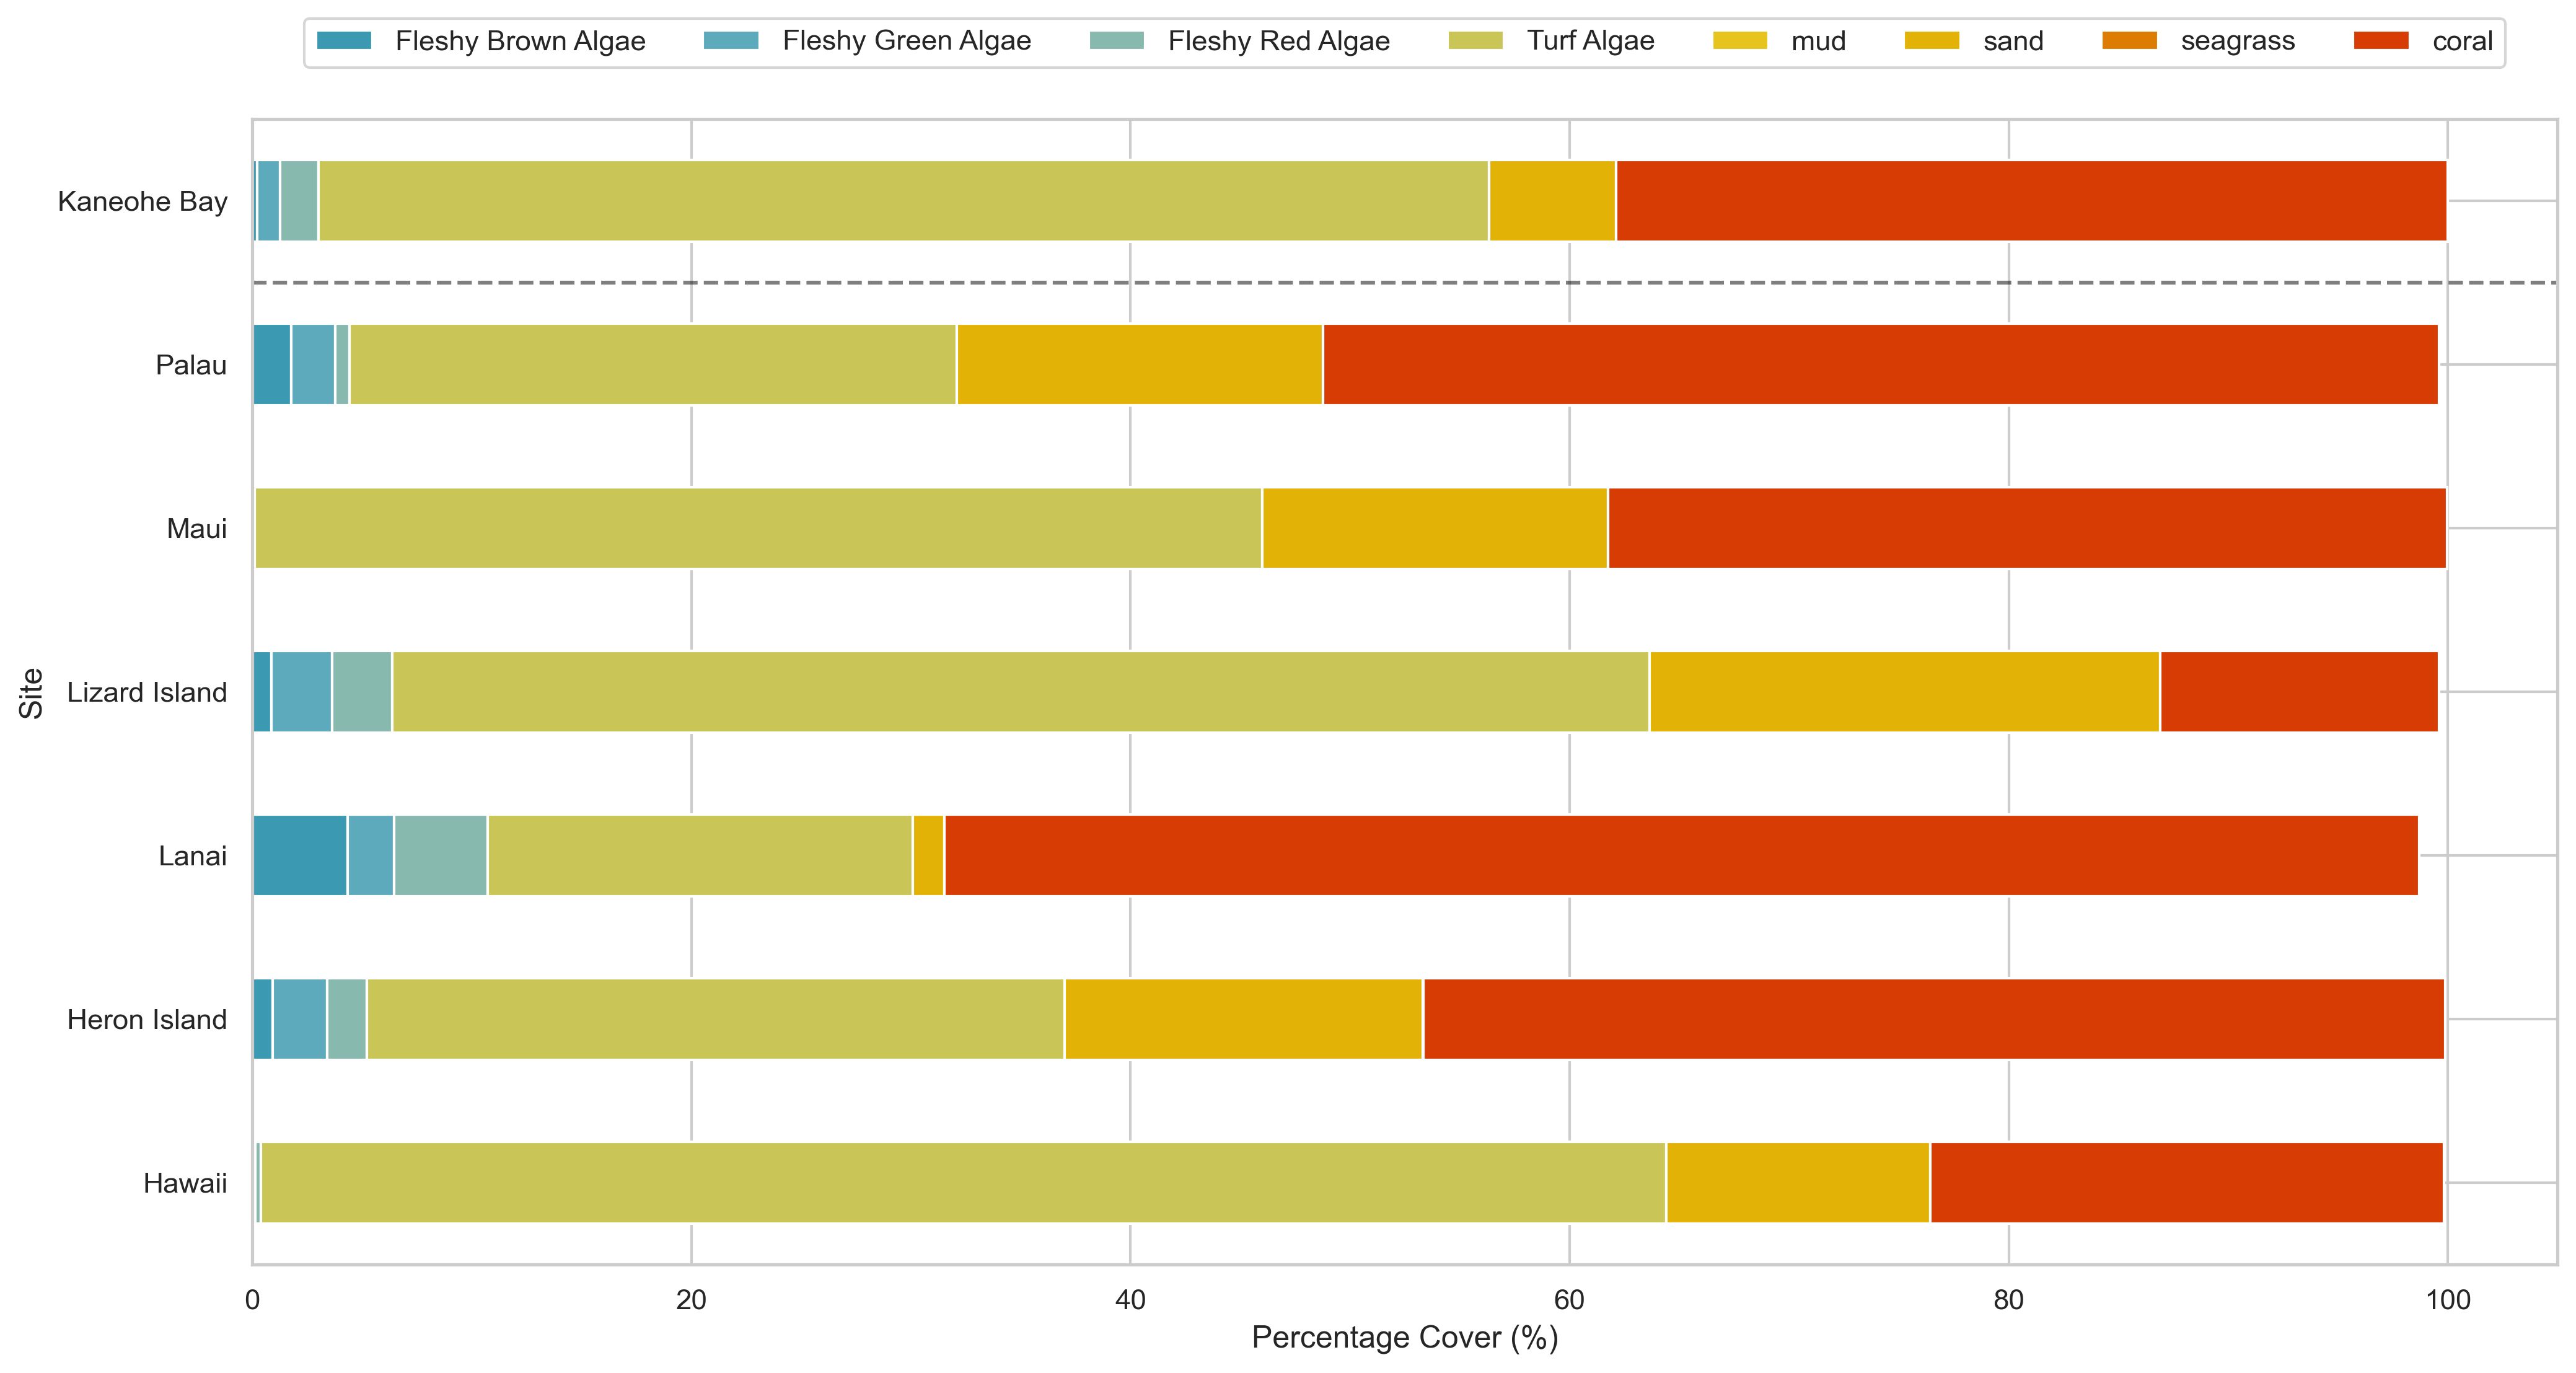

In [ ]:
# Reorder benthic_grouped to have Kaneohe Bay as the first entry
benthic_grouped = benthic_grouped.reindex([loc for loc in benthic_grouped.index if loc != 'Kaneohe Bay'] + ['Kaneohe Bay'])

# Plot stacked bar chart for each locale
fig, ax = plt.subplots(figsize=(16, 8), dpi=300)
benthic_colours = [mcolors.rgb2hex(cmap(step)) for step in np.linspace(0, 1, len(benthic_grouped.columns))]

stacked = benthic_grouped.plot(kind="barh", stacked=True, ax=ax, color=benthic_colours)
ax.set_ylabel("Site")
ax.set_xlabel("Percentage Cover (%)")
ax.legend(ncol=len(benthic_grouped.columns), loc="upper center", bbox_to_anchor=(0.5, 1.1))
ax.axhline(5.5, color="black", linestyle="--", alpha=0.5);